# Semesterprojekt: Retourenvorhersage
Data Mining & Grundlagen Maschinelles Lernen 1, Wintersemester 2022/23

**Gruppe:**

|Paul|Antonio|Tim|Flo|
|---|---|---|---|
|hopa1029|coan1014|ehti1011|klfl1012|
80001|       |80055|79679|

**Gliederung:**
1. Data Cleaning, Feature Engineering und Funktionen
   - 1.1 Data Cleaning
  
   - 1.2 Featrue Engineering
  
   - 1.3 Funktionen
   
2. Klassifikaitonsmodelle mit Hyperparameteroptimierung:
   - 2.1 Logistische Regression 
  
   - 2.2 Decision Tree Classifier
     - 2.2.1 Random Forest 
      
     - 2.2.2 Gradient Boosting   
   
  
   - 2.3 Super Vector Machine

                  
3. Evaluation mit ROC Plot 

4. Aufgabe 5

**Imports:**

In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score, precision_score, ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

import matplotlib.pyplot as plt

**Original Datensatz:**

Der Datensatz beschreibt 75,007 bestellte Artikel, von denen bekannt ist, ob sie zurückge
sendet wurden oder nicht.  
Für einen bestellten Artikel (1 Zeile) existieren folgende Felder in den Daten:

- order_item_id: ID des bestellten Artikels
- order_date: Datum der Bestellung
- delivery_date: Lieferdatum des Artikels
- item_id: ID des Artikels
- item_size: Größe des Artikels
- item_color: Farbe des Artikels
- brand_id: Hersteller ID
- item_price: Preis des Artikels
- user_id: ID des Nutzers
- user_title: Titel des Nutzers
- user_dob: Geburtsdatum des Nutzers
- user_state: Bundesland, in dem der Nutzer wohnt
- user_reg_date: Datum, an dem sich der Nutzer registriert hat
- return: Wurde der Artikel zurückgeschickt (1) oder nicht (0)

In [19]:
df = pd.read_csv("retouren.csv")

In [23]:
df.head()

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,user_dob,user_state,user_reg_date,return
0,1,2016-06-22,2016-06-27,643,38,navy,30,49.90,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
1,2,2016-06-22,NaN,337,152,grey,30,19.95,30822,Mrs,1969-04-17,Saxony,2016-06-23,0
2,3,2016-06-22,2016-06-27,270,xxl,grey,49,79.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1
3,4,2016-06-22,2016-06-27,142,xxl,grey,49,99.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,0
4,5,2016-06-22,2016-06-27,561,xxl,grey,3,14.90,30823,Mrs,1970-04-22,Baden-Wuerttemberg,2015-03-15,1


## 1. Data Cleaning, Feature Engineering und Funktionen

### 1.1 Data Cleaning

**Löschen und Beheben von Datenfehlern und Inkonsistenten im Datensatz**

In [20]:
# Data Cleaning:

# Anpassen der Datentypen
df["user_dob"] = pd.to_datetime(df.user_dob)
df["user_reg_date"] = pd.to_datetime(df.user_reg_date)
df["order_date"] = pd.to_datetime(df.order_date)
df["delivery_date"] = pd.to_datetime(df.delivery_date)

# Löschen der Datensätze mit Preis von 999
df = df.drop(df[df.item_price == 999].index)

# Löschen der Datensätze wo das Lieferdatum kleiner dem Bestelldatum
df = df.drop(df[df.delivery_date < df.order_date].index)

# Anpassen der Dateninkonsistenzen bei item_color
df = df.drop(df[df.item_color == "?"].index)
df.loc[df.item_color == "brwon","item_color"] = "brown"
df.loc[df.item_color == "blau","item_color"] = "blue"
df.loc[df.item_color == "dark oliv","item_color"] = "dark olive"

# Löschen der Datensätze ohne delivery_date
df.drop(df[df.delivery_date.isna()].index, inplace=True)

### 1.2 Feature Engineering

**Datensatz mit neuen Features:**

Der Datensatz wurde für die Modelle um folgenden Features erweitert:

- age: Alter der User zum Zeitpunkt der Bestellung, Differenz zwischen order_date und user_dob
- acc_age: Accountalter des Nutzers zum Zeitpunkt der Bestellung, (-) wenn nach der Bestellung regisrtiert
- maxprice: Der Maximalpreis eines Produktes
- markdown: Ist der Artikel im Vergleich zu maxprice vergünstig (1) oder nicht (0) 
- order_id: ID einer Bestellung
- order_size: Größe einer Bestellung
- return_ratio: Relative Häufigkeit wie oft eine Item zurückgegeben wurde in der Historie der Bestellungen, Wert zwischen 0 und 1
- nth_order_of_user: Die wie vielte Bestellung eines Users
- item_id_>1_in_order: Anzahl der Item ID`s in einer Bestellung, falls diese mehrere hat
- 
- 
- 
- 
-  noch hinzufügen!:
-  item_id_ordered_previously

In [21]:
# Feature Engineering:

# age
df["age"] = df.order_date.dt.year - df.user_dob.dt.year -((df.order_date.dt.date)<(df.user_dob.dt.date))

# age bins
df.loc[df.age > 100, "age"] = df.loc[df.age > 100, "age"] - 100
bins=[0,10,20,30,40,50,60,70,80,90,100]
df["age"] = pd.cut(df.age,bins=bins)

# acc_age
df["acc_age"] = df.order_date - df.user_reg_date 
df["acc_age"] = df.acc_age.dt.days

# maxprice and markdown
df_mark = df.groupby(["item_id","item_size","item_color"]).agg(maxprice=("item_price","max")).reset_index()
df = pd.merge(df,df_mark)
df["markdown"] = 0
df.loc[df.item_price < df.maxprice,"markdown"] = 1

# order_id und order_size
order_id_generator = df.groupby(['order_date', 'user_id'], sort= False).size().reset_index(name='order_size')
order_id_generator['order_id'] = order_id_generator.index
df = pd.merge(df,order_id_generator,on=['user_id', 'order_date'], how='left')

# return_ratio 
df_return_ratio = df.groupby("item_id").agg(returned = ("return", "sum"), item_order= ("return", "count")).reset_index()
df_return_ratio["not_returned"] = df_return_ratio.item_order - df_return_ratio.returned
df_return_ratio["return_ratio"] = df_return_ratio.returned / df_return_ratio.item_order
df_return_ratio.drop(["returned","item_order","not_returned"],axis=1,inplace=True)
df = pd.merge(df,df_return_ratio,on="item_id",how="left")

# nth_order_of_user
df_nth_order_of_user = df.groupby(['user_id', 'order_id'], as_index=False).size().drop('size', axis=1)
df_nth_order_of_user['nth_order_of_user'] = df_nth_order_of_user.groupby(['user_id']).cumcount()+1
df = pd.merge(df,df_nth_order_of_user,on=['user_id', 'order_id'], how='left')

# item_id_>1_in_order
item_counts_in_order = df.groupby(['order_id', 'item_id'], as_index=False).size()
item_counts_in_order['item_id_>1_in_order'] = item_counts_in_order['size'] > 1
df = pd.merge(df,item_counts_in_order[['order_id', 'item_id', 'item_id_>1_in_order']],on=['order_id', 'item_id'], how='left')

In [26]:
df.columns

Index(['order_item_id', 'order_date', 'delivery_date', 'item_id', 'item_size',
       'item_color', 'brand_id', 'item_price', 'user_id', 'user_title',
       'user_dob', 'user_state', 'user_reg_date', 'return', 'age', 'acc_age',
       'maxprice', 'markdown', 'order_size', 'order_id', 'return_ratio',
       'nth_order_of_user', 'item_id_>1_in_order'],
      dtype='object')

In [27]:
df.head()

,order_item_id,order_date,delivery_date,item_id,item_size,item_color,brand_id,item_price,user_id,user_title,...,return,age,acc_age,maxprice,markdown,order_size,order_id,return_ratio,nth_order_of_user,item_id_>1_in_order
0,1,2016-06-22,2016-06-27,643,38,navy,30,49.9,30822,Mrs,...,0,47.0,-1,49.9,0,1,0,0.166667,1,False
1,763,2016-06-24,2016-06-26,643,38,navy,30,49.9,29306,Mrs,...,0,43.0,7,49.9,0,1,1,0.166667,1,False
2,3,2016-06-22,2016-06-27,270,xxl,grey,49,79.9,30823,Mrs,...,1,46.0,465,79.9,0,9,2,0.578125,1,False
3,522,2016-06-23,2016-06-26,270,xxl,grey,49,79.9,11260,Mrs,...,0,66.0,426,79.9,0,9,3,0.578125,1,False
4,25884,2016-07-03,2016-07-04,270,xxl,grey,49,79.9,1283,Mrs,...,1,49.0,292,79.9,0,3,4,0.578125,1,False


### 1.3 Funktionen 

**Funktionen:**

Folgende Funktionen wurden programmiert:
- plot_cunfusion_matrix(): Plotten von Confusion Matrizen
- plot_roc_curve(): Plotten von einem oder mehreren ROC-Diagrammen
- print_evaluation(): Einheitliche Rückgabe von Accuracy-, Recall- und Precision-Score des verwendeten Modells
- calc_model_cost(): Kalkuliert die Kosten die man sich durch das Modell sparen kann oder anfallen. 

In [22]:
# Funktionen

def plot_confusion_matrix(y_test, y_pred, color: str, colorbar: bool, normalize: str):
    """
    plot_confusion_matrix plottet eine Confusion Martrix in From der vergebenen Parametern.

    y_test (array): Label der Testdaten das es hervorzusagen gilt
    y_pred (array): Labels das tatsächlich hervorgesagt wurden
    color (str): Farbe der Confusion Matrix (Achtung!: nur ausgewählte Colorsets von sklearn/matplotlib)
    colorbar (bool): Soll eine Colorbar als Legende angezeigt werden, ja (True) und nein (False) 
    normalize (str): Sollen die Häufigkeiten relativ angezeigt werden, ja "true" neine "false"  

    """
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap= color, colorbar= colorbar, normalize= normalize)


def plot_roc_curve(X_test, y_test, y_predict):
    """ 
    plot_roc_curve erstellt für eine oder mehrere Modelle aus den angegebenen Parametern ein ROC-Diagramm.

    X_test (array): Features des Testdatensatzes
    y_test (array): Label des Testdatensatzes
    y_predict (array): Ein Array, mit einem oder mehreren Arrays drinnen, deren Values eine spezifische Reihenfolge besitzen: 1. Modell, 2. y_pred (tatsächliche hervorgesagte Labelwerte), 3. Titel/Anzeigename in der Graphik (str)    

    Beispielaufruf: plot_roc_curve(X_test= X_test, y_test= y_test, y_predict= [[best_gbc, y_pred_test_best_gbc, "GBC"], [best_dtc, y_pred_test_best_dtc, "DTC"]])
    """
    plt.figure(figsize= (20,10))
    
    for model in y_predict:
        fpr, tpr, thr = roc_curve(y_test, model[0].predict_proba(X_test)[:,1])
        auc = roc_auc_score(y_test, model[1])
        plt.step(x=fpr, y=tpr, label=f"{model[2]} (AUC = {auc.round(2)})")

    plt.legend()


def print_evaluation(pipeline_or_model: str, X_train, X_test, y_train, y_test, y_train_pred, y_test_pred):
    """ 
    print_evaluation gibt den Accuracy-, Recall- und Precision-Score des verwendeten Modells zurück.

    pipeline_or_mode (str): Pipeline oder Modellname
    X_train (array): Features des Trainingsdatensatzes
    X_test (array): Features des Testdatensatzes
    y_train (array): Label der Trainingsdaten das es hervorgzusagen gilt
    y_test (array): Label der Testdaten das es hervorzusagen gilt
    y_train_pred (array): Vorhergesagtes Label auf den Trainingsdaten
    y_test_pred (array): Vorhergesagtes Labl auf den Testdaten
    """
    accurary_train = accuracy_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)

    accurary_test = accuracy_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    
    print(
        f"{pipeline_or_model} Evaluation:\n"
        f"{'':6} {'ACC':>10} | {'REC':>14} | {'PRE':>10} | {'rows':>8} | {'columns':>8}\n"
        f"{'Train':6} {accurary_train:10.5f} | {recall_train:14.5f} | {precision_train:10.5f} | {X_train.shape[0]:8} | {X_train.shape[1]:8}\n"
        f"{'Test':6} {accurary_test:10.5f} | {recall_test:14.5f} | {precision_test:10.5f} | {X_test.shape[0]:8} | {X_test.shape[1]:8}\n"
    )


def calc_model_cost(y_test,y_pred,X_test,Modelname: str):
    """
    Die Funktion Aufgabe6 gibt einen String mit zurück, der das bestimmete Modell nennt und ihren Wert angibt, den Sie auf den Testdaten erzielen würde.

    y_test: label array der Testdaten
    y_pred: die label die das entsprechende Modell auf den Testdaten(testfeatures) hervorgesagt hat
    X_test: Features der Testdaten
    Modelname: Name des Model als string
    """
    df_aufgabe6 = X_test.copy()
    Modelname = Modelname
    df_aufgabe6["return_predict"] = y_pred
    df_aufgabe6["return_test"] = y_test
    df_aufgabe6["Abgleich"] = df_aufgabe6.return_predict == df_aufgabe6.return_test
    df_aufgabe6 = df_aufgabe6.drop(df_aufgabe6.loc[(df_aufgabe6.return_predict == 0)&(df_aufgabe6.Abgleich == True)].index)
    df_aufgabe6["summe"] = 0
    df_aufgabe6.loc[df_aufgabe6.Abgleich == True,"summe"]  = 3.5 # Wir sagen dass wir bei richtige Vorhersage ein Plus von 3.5€ erreichen
    df_aufgabe6.loc[(df_aufgabe6.Abgleich == False)&(df_aufgabe6.return_predict == 1),"summe"] = df_aufgabe6.item_price*(-0.1)*0.5 # bei fälschlicher Vorhersage einer Retoure gehen wir von einem Verlust von 50% des 10%tigen itemprice
    df_aufgabe6.loc[(df_aufgabe6.Abgleich == False)&(df_aufgabe6.return_predict == 0),"summe"] = -7 # beim nicht erkennen einer Retoure gehen wir von einem Verlust von 7€ aus
    print(f"Das Modell {Modelname} würde auf den jetzigen Testdaten einen Bonus von {df_aufgabe6.summe.sum()} erschaffen")

## 2. Klassifikaitonsmodelle mit Hyperparameteroptimierung

### Trainings- und Testdaten

Hier Testdaten einfügen (falls keine Datenfehler):

In [23]:
df_classifier = df.copy()

# Festlegen von Featuren und Label
X = pd.get_dummies(df_classifier[["item_id","item_size", "item_color",	"brand_id",	"item_price",	"user_id",	"user_title",	"user_state",	"age",	"acc_age",	"markdown", "return_ratio"]], dummy_na= True)
y = df_classifier["return"]

# Aufteilung in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 2.1 Logisitsche Regression

### 2.2 Decision Tree Classifier

#### Basismodell Decision Tree Classifier

Mittels einer 10-Fachen Kreuzvalidierung und Hyperparametertuning wird die beste Kombination aus Baumtiefe (max_depth) und minimaler Anzahl an benötigter Beispiele für einen Split (min_samples) gesucht:

In [26]:
min_samples = [2, 10, 20, 50, 100]
kf = KFold(n_splits= 10, shuffle= True, random_state= 1)
best_mean_score = 0
best_combination = dict(max_depth= None, min_samples= 2)

for depth in range(1,19):
 for min_sample in min_samples:
  scores = []
  classifier = DecisionTreeClassifier(max_depth= depth, min_samples_split= min_sample, random_state= 0)
  if classifier.fit(X_train, y_train).tree_.max_depth < depth:
   break
  score = np.mean(cross_val_score(classifier, X_train, y_train, scoring= "accuracy", cv= kf, n_jobs= 1))
  scores.append(score)

  mean_score = np.mean(np.array(scores))
 if mean_score > best_mean_score:
  best_combination["max_depth"] = depth
  best_combination["min_samples"] = min_sample
  best_mean_score = mean_score

print(f"Best Mean_score: {best_mean_score}, Best Max_depth: {best_combination['max_depth']}, Best Min_samples_split: {best_combination['min_samples']}")

Best Mean_score: 0.6241114025369927, Best Max_depth: 5, Best Min_samples_split: 100


Auführen des Classifiers mit einer Baumtiefe von 5 und 100 Auteilungen 

In [27]:
best_dtc = DecisionTreeClassifier(max_depth= best_combination["max_depth"], min_samples_split= best_combination["min_samples"], random_state= 0)
best_dtc.fit(X_train, y_train)

y_pred_train_best_dtc = best_dtc.predict(X_train)
y_pred_test_best_dtc = best_dtc.predict(X_test)

In [28]:
print_evaluation("DecisionTreeClassifier", X_train, X_test, y_train, y_test, y_pred_train_best_dtc, y_pred_test_best_dtc)

DecisionTreeClassifier Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.62882 |        0.67056 |    0.62342 |    52888 |      214
Test      0.62963 |        0.66861 |    0.62514 |    13222 |      214



#### 2.2.1 Random Forest

#### 2.2.1 Gradient Boosting Classifier

Um die Parameterwerte zu finden, die die höchste Genauigkeit erzielen, wird die Kreuzvalidierungsmethode GridSearchCV verwendet:

In [29]:
gs_crossvalidation1 = GridSearchCV(
 estimator= HistGradientBoostingClassifier(),
 param_grid= dict(max_iter= [100], learning_rate= [0.001, 0.01, 0.1], max_depth= [1,3,5,9], random_state= [1]),
 scoring= "accuracy",
 n_jobs= -1,
 cv= kf
 ).fit(X_train, y_train)
print(f"Best parameters: {gs_crossvalidation1.best_params_}, best score: {gs_crossvalidation1.best_score_}")

Best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'max_iter': 100, 'random_state': 1}, best score: 0.6328467455504517


Anschließend wird Classifier mit den optimierten Hyperparametern ausgeführt

In [30]:
best_gbc = HistGradientBoostingClassifier(max_iter= 100, max_depth= 9, random_state= 1, learning_rate= 0.1).fit(X_train, y_train)

y_pred_train_best_gbc = best_gbc.predict(X_train)
y_pred_test_best_gbc = best_gbc.predict(X_test)

print_evaluation("GradientBoostingClassifier", X_train, X_test, y_train, y_test, y_pred_train_best_gbc, y_pred_test_best_gbc)

GradientBoostingClassifier Evaluation:
              ACC |            REC |        PRE |     rows |  columns
Train     0.65556 |        0.68096 |    0.65256 |    52888 |      214
Test      0.63561 |        0.65725 |    0.63502 |    13222 |      214



### 2.3 Super Vector Machine

## 3. Evaluation mit ROC-Plot

**Für die Evaluation werden mittels eines ROC-Plost alle Klassifizierungsmodelle miteinander verglichen:**

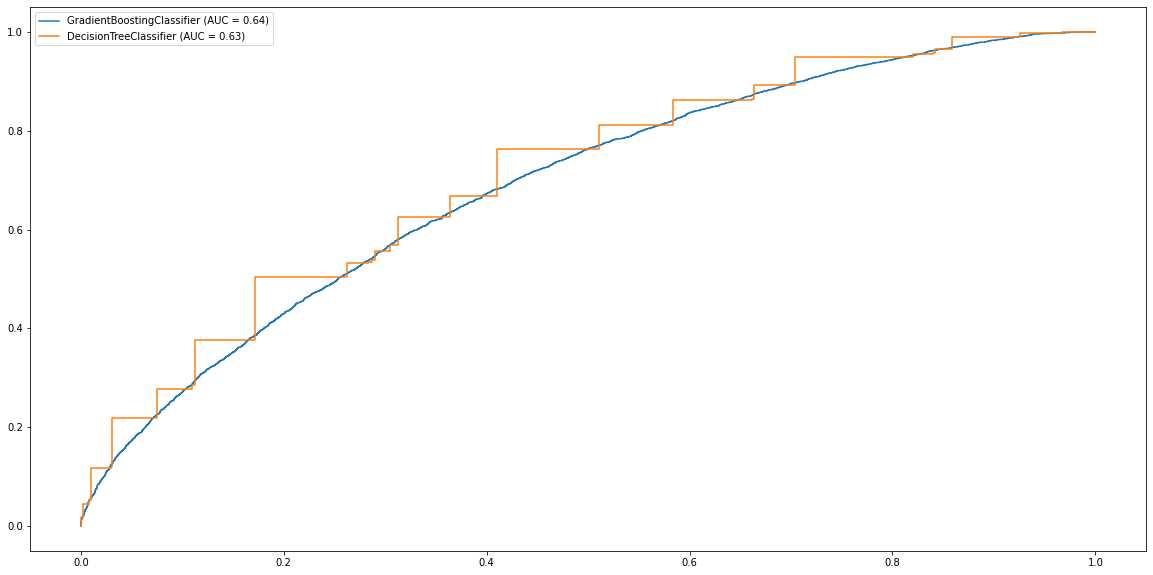

In [32]:
plot_roc_curve(X_test, y_test, 
 y_predict= [
  [best_gbc, y_pred_test_best_gbc, "GradientBoostingClassifier"],
  [best_dtc, y_pred_test_best_dtc, "DecisionTreeClassifier"]
  ]
 )

## 4. Aufgabe 6